In [2]:
# Accessing My Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


**IMPORT LIBRARY**

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import math
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

# **2. Data Preparation**

### **2.1  Data Souce**

In [4]:
# Load dataset from Google Drive
data = pd.read_csv('/content/drive/MyDrive/Project/AI/plant_growth_data.csv')

In [10]:
data.head()

,Soil_Type,Sunlight_Hours,Water_Frequency,Fertilizer_Type,Temperature,Humidity,Growth_Milestone
0,loam,5.192294,bi-weekly,chemical,31.719602,61.591861,0
1,sandy,4.033133,weekly,organic,28.919484,52.422276,1
2,loam,8.892769,bi-weekly,none,23.179059,44.660539,0
3,loam,8.241144,bi-weekly,none,18.465886,46.433227,0
4,sandy,8.374043,bi-weekly,organic,18.128741,63.625923,0


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Soil_Type         193 non-null    object 
 1   Sunlight_Hours    193 non-null    float64
 2   Water_Frequency   193 non-null    object 
 3   Fertilizer_Type   193 non-null    object 
 4   Temperature       193 non-null    float64
 5   Humidity          193 non-null    float64
 6   Growth_Milestone  193 non-null    int64  
dtypes: float64(3), int64(1), object(3)
memory usage: 10.7+ KB


### **2.2  Data Cleaning**

In [12]:
# Create DataFrame and clean data
df = pd.DataFrame(data.values, columns=['Soil_Type','Sunlight_Hours','Water_Frequency','Fertilizer_Type','Temperature', 'Humidity', 'Growth_Milestone'])

df = df.drop('Soil_Type', axis=1)
df = df.drop('Water_Frequency', axis=1)
df = df.drop('Fertilizer_Type', axis=1)

# Convert columns to float
df['Sunlight_Hours'] = df['Sunlight_Hours'].astype('float')
df['Temperature'] = df['Temperature'].astype('float')
df['Humidity'] = df['Humidity'].astype('float')
df['Growth_Milestone'] =df['Growth_Milestone'].astype('float')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Sunlight_Hours    193 non-null    float64
 1   Temperature       193 non-null    float64
 2   Humidity          193 non-null    float64
 3   Growth_Milestone  193 non-null    float64
dtypes: float64(4)
memory usage: 6.2 KB


### **2.3  Data Transformation**

In [14]:
# สร้างฟังก์ชันสุ่มข้อมูลใหม่
def generate_new_data(num_samples):
    # สุ่มค่าจากช่วงที่กำหนดสำหรับแต่ละคอลัมน์
    sunlight = np.random.uniform(1, 5, num_samples)
    temperature = np.random.uniform(15, 37, num_samples)
    humidity = np.random.uniform(30, 80, num_samples)

    # คำนวณ score เพื่อใช้ในการสุ่มค่า Growth_Milestone
    score = 0.3 * sunlight + 0.4 * temperature + 0.3 * humidity  # น้ำหนักตามความสำคัญ

    # Normalize score ให้อยู่ในช่วง [0, 1]
    score_normalized = (score - score.min()) / (score.max() - score.min())

    # สุ่มค่า Growth_Milestone โดยพิจารณาค่า score เป็นความน่าจะเป็น
    growth_milestone = np.random.binomial(1, score_normalized)  # 1 = เติบโตดี, 0 = ไม่เติบโตดี

    # สร้าง DataFrame ของข้อมูลใหม่
    new_data = pd.DataFrame({
        'Sunlight_Hours': sunlight,
        'Temperature': temperature,
        'Humidity': humidity,
        'Growth_Milestone': growth_milestone
    })

    return new_data

# สร้างข้อมูลใหม่ 5000 ตัวอย่าง
augmented_data = generate_new_data(10000)

# รวมข้อมูลใหม่กับข้อมูลเดิม
df_augmented = pd.concat([df, augmented_data], ignore_index=True)

# แยก features และ labels ออก
X = df_augmented.drop('Growth_Milestone', axis=1)
y = df_augmented['Growth_Milestone']

# แบ่งข้อมูลเป็น train และ test (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [247]:
df_augmented.tail()

,Sunlight_Hours,Temperature,Humidity,Growth_Milestone
10188,4.196183,27.299360,41.047061,0.0
10189,3.441935,27.723494,57.308401,0.0
10190,2.985113,15.661474,45.736801,0.0
10191,1.383402,20.047685,58.268599,1.0
10192,2.079721,19.402827,41.328276,0.0


In [ ]:
# Separate features and labels
X = df_augmented.drop('Growth_Milestone', axis=1)
y = df_augmented['Growth_Milestone']

# Split the dataset into training and testing sets (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# **3.  Train**

### **3.1  AI Model**

In [16]:
# Build a Neural Network model with TensorFlow (similar to Random Forest but using dense layers)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],),kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)),
    tf.keras.layers.BatchNormalization(),  # Batch Normalization
    tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),  # Regularization
    tf.keras.layers.Dense(32, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation = 'sigmoid')])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### **3.2  Hyperparameters**

In [17]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mae'])

In [18]:
# สร้าง EarlyStopping Callback
early_stopping = EarlyStopping(monitor='val_loss',  patience=3,  restore_best_weights=True )

### **3.3  Model Training**

In [19]:
# Train the model
history = model.fit(X_train, y_train, epochs=70, batch_size=16, validation_split=0.1,callbacks=[early_stopping])

Epoch 1/70
402/402 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 7.1019 - mae: 0.4321 - val_loss: 1.5016 - val_mae: 0.4767
Epoch 2/70
402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.2474 - mae: 0.4167 - val_loss: 0.8672 - val_mae: 0.4445
Epoch 3/70
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8521 - mae: 0.4311 - val_loss: 0.7893 - val_mae: 0.4006
Epoch 4/70
402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.7680 - mae: 0.4245 - val_loss: 0.7401 - val_mae: 0.4369
Epoch 5/70
402/402 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.7020 - mae: 0.4277 - val_loss: 0.6777 - val_mae: 0.4190
Epoch 6/70
402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6935 - mae: 0.4314 - val_loss: 0.6935 - val_mae: 0.4652
Epoch 7/70
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6749 - mae: 0.4273 - val_loss: 0.6754 - val_mae: 0.4385
Epoch 8/70
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6637 - mae: 0.4257 - val_loss: 0.6564 - val_mae: 0.4348
Epoch 9/70
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

# **4.  Test Model**

### **4.1  การประเมินผล**

In [20]:
# Predict values
y_pred = model.predict(X_test)

# แปลงค่าให้อยู่ในรูป 0 หรือ 1
y_pred_binary = (y_pred > 0.5).astype(int)

# แสดงผลลัพธ์
print("Predicted values:", y_pred_binary.flatten())

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Predicted values: [1 1 1 ... 1 0 1]


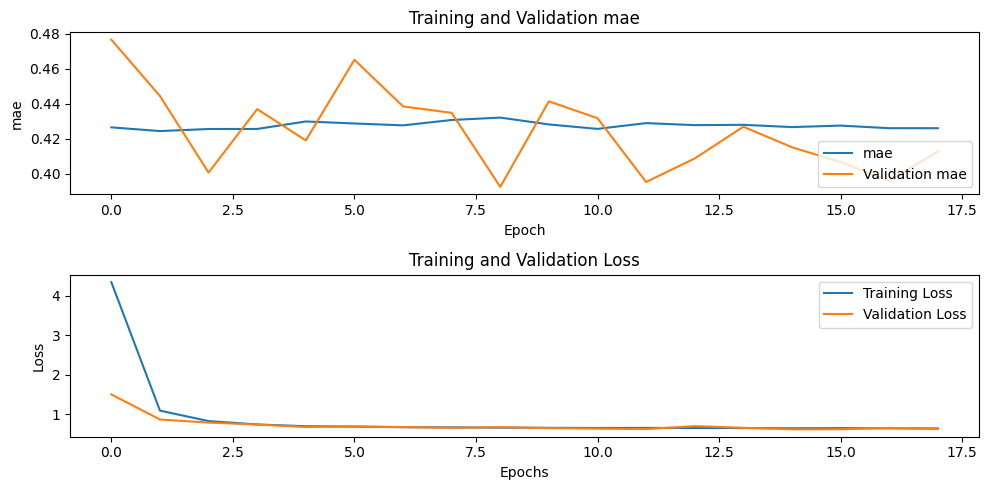

In [21]:
# Create a figure and a set of subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))

# Plot training and validation MAE
ax1.plot(history.history['mae'], label='mae')
ax1.plot(history.history['val_mae'], label='Validation mae')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('mae')
ax1.legend(loc='lower right')
ax1.set_title('Training and Validation mae')

# Plot training and validation loss
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.set_title('Training and Validation Loss')

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

In [22]:
# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)

Mean Squared Error (MSE): 0.2081541603872952
Root Mean Squared Error (RMSE): 0.45623914824058576
R-squared (R2): 0.1673659068488651


In [23]:
# Test the model with sample data
sample_data = np.array([2, 30, 50]).reshape(1, -1)

# Predict the value using the model
sample_pred = model.predict(sample_data)

# แปลงผลลัพธ์ให้เป็น 0 หรือ 1
sample_pred_binary = (sample_pred > 0.5).astype(int)

# แสดงผลลัพธ์เป็นข้อความ
if sample_pred_binary[0][0] == 1:
    print("Growth Rate Prediction: เติบโตได้ดี")
else:
    print("Growth Rate Prediction: เติบโตได้ไม่ดี")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
Growth Rate Prediction: เติบโตได้ดี


# **Save Model**

In [254]:
# Convert the trained model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Enable quantization for optimization
tflite_model = converter.convert()

# Save the TFLite model
with open('/content/drive/MyDrive/Project/AI/myทำนายproject.tflite', 'wb') as f:
    f.write(tflite_model)

print("TFLite model saved successfully!")

Saved artifact at '/tmp/tmpm3rz4557'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 3), dtype=tf.float32, name='keras_tensor_150')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140531684588560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140531684772848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140531684771968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140531684774080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140531684770384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140531684773552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140531684774432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140531684778832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140531684778656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140531684779536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140531684771440: Ten